In [2]:

import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as skl_pre
import sklearn.datasets
import random
import math
import copy

## "a9a" UCI Adult Dataset from:
## https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html
## Data was loaded in by sklearn.datasets.load_svmlight_file
## This model uses the l2 regularized SVM loss. 
## Stochastic Subgradient Descent is used.



## Gradient of Loss functions:

## Computes the subgradient of the SVM loss, returns that subgradient vector.
## Given a data vector x, label y of {1, -1}, and parameter vector w
def subgradloss(x, y, w):
	val = 1- y*(w @ x)
	if val > 0:
		return (-1)*y*x
	elif val == 0:
		subg = np.random.uniform(0,1)
		return ((-subg)*y*x) 
	return 0

## Compute regularizer subgradient of w, returns the subgradient vector
## given a parameter vector w.
def subgradreg(w):
	wgrad = copy.deepcopy(w)
	wgrad[0] = 0 ## make sure we don't regularize bias term
	return 2*wgrad


## Run Methods ##

## Read in Data, Shuffle D ## 
raw_train = sklearn.datasets.load_svmlight_file("a9a.txt")
raw_test = sklearn.datasets.load_svmlight_file("a9a.t")

## 32561 X 122
D_train_nonaug = raw_train[0][:,0:raw_train[0].shape[1]-1]
y_train = raw_train[1]
D_train_nonaug = D_train_nonaug.toarray()
D_test_nonaug = raw_test[0].toarray()
y_test = raw_test[1]

## Standardize Features to Standard Gaussians ##
scaler = skl_pre.StandardScaler()
D_train_nonaug = scaler.fit_transform(D_train_nonaug)
# use the same transformation on the test set.
D_test_nonaug = scaler.transform(D_test_nonaug)

# augment a vector of ones for ease of bias computation
D_train = np.ones([D_train_nonaug.shape[0], D_train_nonaug.shape[1]+1 ])
D_train[:, 1:] = D_train_nonaug 
D_test = np.ones([D_test_nonaug.shape[0], D_test_nonaug.shape[1]+1 ])
D_test[:, 1:] = D_test_nonaug 

int_n = D_train.shape[0]
int_d = D_train.shape[1]


## D_train holds the {1} augmented training data for ease of bias computation
## y_train is its corresponding labels

## Likewise, D_test similarly holds the {1} augmented testing data.
## y_test is the labels.

In [83]:
## given a data matrix (ndarray) X, ndarray of TRUE labels Y, and a python LIST of ndarrays consisting of
## parameter weights W, for iteration 1 to T, returns the list of fractional classification accuracy of SVM, for each
## parameter ndarray w_t in W.
def accuracy(X,Y,W):
    acclist = []
    for i in range(len(W)):
        pred = np.where(X@W[i] > 0, 1, -1)
        score = Y + pred
        score = np.where(score == 0, 0,1)
        acclist.append(np.mean(score))
    return acclist

## given a data matrix (ndarray) X, ndarray of TRUE labels Y, and a python LIST of ndarrays consisting of
## parameter weights W, for iteration 1 to T, returns the SVM loss, for each parameter ndarray w_t in W.
def loss_svm(X,Y,W, regparam):
    int_n = X.shape[0]
    summed = 0
    for i in range(int_n):
        summed +=np.maximum(0,1- Y[i]*(W.T@X[i]))
    summed /= int_n
    return summed  + (regparam)*(np.linalg.norm(W)**2)
    
## ADAM Method
## Given data matrix (ndarray) X, ndarray of TRUE labels Y, the function subgradloss, subgradreg, 
## 'momentum' parameter beta1 (float), EMA parameter beta2 (float), stepsize eta (float), 
## adaptivity parameter eps (epsilon, float), max iterations T, a minibatch size, "batchsize", 
## and a boolean "print_itr" (if you wish to print each iteration),
## returns a python list of ndarrays of the parameter w_t at each iteration w_t. ALSO returns a python list of loss values
## at each iteration.
def ADAM(X,Y,subgradloss, subgradreg,beta1,beta2,eta, eps, T, batchsize, print_itr):
    tol = 10**(-3) ## Convergence Parameter is hard coded. Adjust here.
    regparam = 1/X.shape[0]
    perm = np.random.permutation(X.shape[0])
    X = X[perm]
    Y = Y[perm]
    mu_old = np.zeros(int_d) ## mu is the m_t term in the paper, "the momentum term"
    D_old = np.zeros(int_d) ## D can be thought of as the v_t term in the paper, "the EMA term"
    W_old = np.zeros(int_d)
    Wblist = [W_old]
    W = np.zeros(int_d)
    num_batch = math.ceil(X.shape[0]/batchsize)
    batchlist = np.array_split(X, num_batch)
    targetlist = np.array_split(Y, num_batch)
    batch_itr = 0
    loss_list = []
    t= 0
    curr_loss = loss_svm(X,Y,W, regparam)
    print("Iteration: {}, Loss: {}".format(t, curr_loss))
    while True:

        if batch_itr == len(batchlist):
            batch_itr = 0
        Wgrad = np.zeros(int_d)
        for x_i,y_i in zip(batchlist[batch_itr],targetlist[batch_itr]):
            Wgrad += subgradloss(x_i, y_i,W)
        Wgrad /= batchsize
        Wgrad += (regparam/2)*subgradreg(W)
        t += 1
        mu = beta1*mu_old + (1-beta1)*Wgrad
        D = (beta2*D_old) + (1-beta2)*(Wgrad**2)
        mu_hat = (mu/(1-(beta1**t)))
        D_hat = (D/(1-(beta2**t)))
        ascent_direction = np.divide(mu_hat, (np.sqrt(D_hat) + eps))
        W = W_old - eta*ascent_direction
        W_old = W
        mu_old = mu
        D_old = D
        Wblist.append( W )
        ## Convergence check ##
        curr_loss = loss_svm(X,Y,W, regparam)
        loss_list.append(curr_loss)
        if print_itr and (t+1)%10 == 0:
            print("Iteration: {}, Loss: {}".format(t, curr_loss))
        if t == T:
            print("Max Iterations Reached")
            return Wblist, loss_list
            break

## YOGI Method: Identical Structure of input/output to ADAM method.
## Given data matrix (ndarray) X, ndarray of TRUE labels Y, the function subgradloss, subgradreg, 
## 'momentum' parameter beta1 (float), EMA parameter beta2 (float), stepsize eta (float), 
## adaptivity parameter eps (epsilon, float), max iterations T, a minibatch size, "batchsize", 
## and a boolean "print_itr" (if you wish to print each iteration),
## returns a python list of ndarrays of the parameter w_t at each iteration w_t. ALSO returns a python list of loss values
## at each iteration.
def YOGI(X,Y,subgradloss, subgradreg,beta1,beta2,eta, eps, T, batchsize, print_itr):
    tol = 10**(-3)
    regparam = 1/X.shape[0]
    perm = np.random.permutation(X.shape[0])
    X = X[perm]
    Y = Y[perm]
    mu_old = np.zeros(int_d)
    D_old = np.zeros(int_d)
    W_old = np.zeros(int_d)
    Wblist = [W_old]
    W = np.zeros(int_d)
    num_batch = math.ceil(X.shape[0]/batchsize)
    batchlist = np.array_split(X, num_batch)
    targetlist = np.array_split(Y, num_batch)
    batch_itr = 0
    loss_list = []
    t= 0
    curr_loss = loss_svm(X,Y,W, regparam)
    print("Iteration: {}, Loss: {}".format(t, curr_loss))
    while True:
        if batch_itr == len(batchlist):
            batch_itr = 0
        Wgrad = np.zeros(int_d)
        for x_i,y_i in zip(batchlist[batch_itr],targetlist[batch_itr]):
            Wgrad += subgradloss(x_i, y_i,W)
        Wgrad /= batchsize
        Wgrad += (regparam/2)*subgradreg(W)
        t += 1
        mu = beta1*mu_old + (1-beta1)*Wgrad
        D = D_old - (1-beta2)*np.sign(D_old - (Wgrad**2))*(Wgrad**2)
        mu_hat = (mu/(1-(beta1**t)))
        D_hat = (D/(1-(beta2**t)))
        ascent_direction = np.divide(mu_hat, (np.sqrt(D_hat) + eps))
        W = W_old - eta*ascent_direction
        W_old = W
        mu_old = mu
        D_old = D
        Wblist.append( W )
        curr_loss = loss_svm(X,Y,W, regparam)
        loss_list.append(curr_loss)
        if print_itr and (t+1)%10 == 0:
            print("Iteration: {}, Loss: {}".format(t, curr_loss))
        if t == T:
            print("Max Iterations Reached")
            return Wblist, loss_list
            break


## Given data matrix (ndarray) X, ndarray of TRUE labels Y, the function subgradloss, subgradreg, 
## stepsize eta (float), adaptivity parameter eps (epsilon, float), max iterations T, a minibatch size, "batchsize", 
## and a boolean "print_itr" (if you wish to print each iteration),
## returns a python list of ndarrays of the parameter w_t at each iteration w_t. ALSO returns a python list of loss values
## at each iteration.
def adagrad(X,Y,subgradloss, subgradreg,eta, eps, T, batchsize, print_itr):
    tol = 10**(-3)
    loss_list = []
    regparam = 1/X.shape[0]
    perm = np.random.permutation(X.shape[0])
    X = X[perm]
    Y = Y[perm]
    W_old = np.zeros(int_d)
    D_old = np.zeros(int_d)
    Wblist = [W_old]
    W = np.zeros(int_d)
    num_batch = math.ceil(X.shape[0]/batchsize)
    batchlist = np.array_split(X, num_batch)
    targetlist = np.array_split(Y, num_batch)
    batch_itr = 0
    t = 0
    curr_loss = loss_svm(X,Y,W, regparam)
    print("Iteration: {}, Loss: {}".format(t+1, curr_loss))
    while True:
        if batch_itr == len(batchlist):
            batch_itr = 0
        Wgrad = np.zeros(int_d)
        for x_i,y_i in zip(batchlist[batch_itr],targetlist[batch_itr]):
            Wgrad += subgradloss(x_i, y_i,W)
        Wgrad /= batchlist[batch_itr].shape[0]
        Wgrad += (regparam/2)*subgradreg(W)
        t += 1
        D = D_old + np.multiply(Wgrad, Wgrad)
        W = W_old - eta *Wgrad/((np.sqrt(D) + eps))
        W_old = W
        D_old = D
        Wblist.append( W )
        curr_loss = loss_svm(X,Y,W, regparam)
        loss_list.append(curr_loss)
        if print_itr and (t+1)%10 == 0:
            print("Iteration: {}, Loss: {}".format(t, curr_loss))
        if t == T:
            print("Max Iterations Reached")
            return Wblist, loss_list
            break



In [68]:
## Standard SGD
## Given data matrix (ndarray) X, ndarray of TRUE labels Y, the function subgradloss, subgradreg, beta1 = 0, beta2 = 0,
## INITIAL stepsize eta (float), ("eps" can be disregarded.) ,max iterations T, a minibatch size, "batchsize", 
## a boolean "print_itr" (if you wish to print each iteration), a decrease stepsize parameter "a",
## returns a python list of ndarrays of the parameter w_t at each iteration w_t. ALSO returns a python list of loss values
## at each iteration.

## SGD is adapted from the YOGI method: In SGD, beta1 = beta2 = 0. There is no "momentum term", nor EMA term. 
## Also note that eta is the INITIAL Stepsize parameter. Inside the function, ALPHA is the modified stepsize, which is
## decreased as follows:   alpha = eta/(1 + a*t), where "a" is our decrement parameter, "t" is our iteration number.
def SGD(X,Y,subgradloss, subgradreg,beta1,beta2,eta, eps, T, batchsize, print_itr, a):
    tol = 10**(-3)
    regparam = 1/X.shape[0]
    perm = np.random.permutation(X.shape[0])
    X = X[perm]
    Y = Y[perm]
    mu_old = np.zeros(int_d)
    D_old = np.zeros(int_d)
    W_old = np.zeros(int_d)
    Wblist = [W_old]
    W = np.zeros(int_d)
    num_batch = math.ceil(X.shape[0]/batchsize)
    batchlist = np.array_split(X, num_batch)
    targetlist = np.array_split(Y, num_batch)
    batch_itr = 0
    loss_list = []
    t= 0
    curr_loss = loss_svm(X,Y,W, regparam)
    print("Iteration: {}, Loss: {}".format(t, curr_loss))
    while True:
        if batch_itr == len(batchlist):
            batch_itr = 0
        Wgrad = np.zeros(int_d)
        for x_i,y_i in zip(batchlist[batch_itr],targetlist[batch_itr]):
            Wgrad += subgradloss(x_i, y_i,W)
        Wgrad /= batchsize
        Wgrad += (regparam/2)*subgradreg(W)
        t += 1
        alpha = eta/(1 + a*t)
        mu = beta1*mu_old + (1-beta1)*Wgrad
        D = D_old - (1-beta2)*np.sign(D_old - (Wgrad**2))*(Wgrad**2)
        mu_hat = (mu/(1-(beta1**t)))
        D_hat = (D/(1-(beta2**t)))
        ascent_direction = np.divide(mu_hat, (np.sqrt(D_hat) + eps))
        W = W_old - alpha*ascent_direction
        W_old = W
        mu_old = mu
        D_old = D
        Wblist.append( W )
        curr_loss = loss_svm(X,Y,W, regparam)
        loss_list.append(curr_loss)
        if print_itr and (t+1)%10 == 0:
            print("Iteration: {}, Loss: {}".format(t, curr_loss))
        if t == T:
            print("Max Iterations Reached") ## put in -1 to run till convergence
            return Wblist, loss_list
            break


In [79]:
eps = 10**(-8)
stoc = 1
hun = 1000
thous = 1000
#############
## RUN SGD ##
#############

## Run 200 iterations of SGD with minibatch of 1000, with initial stepsize eta = 0.1, and decrement parameter "a" = 0.1
## as stated earlier, beta1 = beta2 = 0, which gives us vanilla SGD. The  value of "eps" does not matter.
SGD_weights, SGD_loss = TEST(D_train, y_train, subgradloss, subgradreg, 0.0,0.0,0.1, eps, 200, thous,True, 0.1)


Iteration: 0, Loss: 1.0
Iteration: 9, Loss: 0.7151524133514437
Iteration: 19, Loss: 0.6191877747078532
Iteration: 29, Loss: 0.6177142577173776
Iteration: 39, Loss: 0.6202367983638678
Iteration: 49, Loss: 0.6222367038551706
Iteration: 59, Loss: 0.6183429981941649
Iteration: 69, Loss: 0.620005901817009
Iteration: 79, Loss: 0.6198306524975398
Iteration: 89, Loss: 0.6195321655611036
Iteration: 99, Loss: 0.6184393611167125
Iteration: 109, Loss: 0.6188988025833356
Iteration: 119, Loss: 0.6203992591297168
Iteration: 129, Loss: 0.6192495878969393
Iteration: 139, Loss: 0.6187063671326424
Iteration: 149, Loss: 0.6183642498089947
Iteration: 159, Loss: 0.6182789782914273
Iteration: 169, Loss: 0.618325957308118
Iteration: 179, Loss: 0.6181329111904484
Iteration: 189, Loss: 0.6185336000807254
Iteration: 199, Loss: 0.6183288108236451
Max Iterations Reached


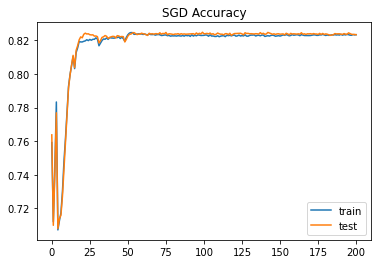

In [136]:
## Compute and Plot initial accuracies of SGD for fine tuning.
sgd_acc = accuracy(D_train, y_train, SGD_weights)
sgd_acc2 = accuracy(D_test, y_test, SGD_weights)

plt.title("SGD Accuracy")
plt.plot(sgd_acc, label = "train")
plt.plot(sgd_acc2, label = "test")
plt.legend()
plt.show()

In [105]:
#############################
## RUN ADAM, YOGI, ADAGRAD ##
#############################

beta1 = 0.9
beta2 = 0.999
eta = 0.01
eps = 10**(-8)
eps_yogi = 10**(-3) ## eps_yogi is the increased adaptivity parameter that Yogi uses.
maxitr = 200
batchsize = 1000
print_itr = True
print("ADAM")
adam_weights, loss_list = ADAM(D_train, y_train, subgradloss, subgradreg, beta1, beta2, eta, eps, maxitr, batchsize, print_itr)
print("YOGI")
yogi_weights = YOGI(D_train, y_train, subgradloss, subgradreg, beta1, beta2, eta, eps_yogi, maxitr, batchsize, print_itr)
print("ADAGrad")
adagrad_weights, ada_loss_list = adagrad(D_train, y_train, subgradloss, subgradreg,  eta,  eps, maxitr, batchsize, print_itr)

ADAM
Iteration: 0, Loss: 1.0
Iteration: 9, Loss: 0.6382046842392304
Iteration: 19, Loss: 0.6498660788001653
Iteration: 29, Loss: 0.6542086228763137
Iteration: 39, Loss: 0.6560907882883493
Iteration: 49, Loss: 0.6640491791518756
Iteration: 59, Loss: 0.6708859036713427
Iteration: 69, Loss: 0.6774719239740965
Iteration: 79, Loss: 0.6887891660026605
Iteration: 89, Loss: 0.7010625371237443
Iteration: 99, Loss: 0.7131075763141813
Iteration: 109, Loss: 0.7259220137862282
Iteration: 119, Loss: 0.7374359107905367
Iteration: 129, Loss: 0.7475993617534965
Iteration: 139, Loss: 0.755828553508171
Iteration: 149, Loss: 0.7648740408240263
Iteration: 159, Loss: 0.7731326961219229
Iteration: 169, Loss: 0.7813487723931439
Iteration: 179, Loss: 0.7886097556809181
Iteration: 189, Loss: 0.7948897635350529
Iteration: 199, Loss: 0.8013417122483204
Max Iterations Reached
YOGI
Iteration: 0, Loss: 1.0
Iteration: 9, Loss: 0.6355990594395359
Iteration: 19, Loss: 0.6148125831088225
Iteration: 29, Loss: 0.603740354

In [110]:
## Compute Adam with epsilon = 10^{-3}, This will be used for the adaptivity parameter plots. 
adam_weights_2, loss_list_2 = ADAM(D_train, y_train, subgradloss, subgradreg, beta1, beta2, eta, eps_yogi, maxitr, batchsize, print_itr)


Iteration: 0, Loss: 1.0
Iteration: 9, Loss: 0.6364403319858856
Iteration: 19, Loss: 0.6435237824798515
Iteration: 29, Loss: 0.6438284315113094
Iteration: 39, Loss: 0.6373273309973199
Iteration: 49, Loss: 0.627413221541703
Iteration: 59, Loss: 0.6292036491017862
Iteration: 69, Loss: 0.6333279887241705
Iteration: 79, Loss: 0.6392572409599327
Iteration: 89, Loss: 0.6469490151648045
Iteration: 99, Loss: 0.6533371288986908
Iteration: 109, Loss: 0.6587659474272203
Iteration: 119, Loss: 0.6638335092042639
Iteration: 129, Loss: 0.6696395960960081
Iteration: 139, Loss: 0.6730242652522476
Iteration: 149, Loss: 0.6771305269317198
Iteration: 159, Loss: 0.6800790474435051
Iteration: 169, Loss: 0.684371778877511
Iteration: 179, Loss: 0.6878417984696487
Iteration: 189, Loss: 0.691806553239525
Iteration: 199, Loss: 0.6939054009018973
Max Iterations Reached


In [106]:
## Compute list of accuracies for train & test sets. ##
## for example, adam_acc is the list of accuracies of the training data, 
## adam_acc2 is the list of accuracies of the test data.
adam_acc = accuracy(D_train, y_train, adam_weights)
adam_acc2 = accuracy(D_test, y_test, adam_weights)
adagrad_acc = accuracy(D_train, y_train, adagrad_weights)
yogi_acc = accuracy(D_train, y_train, yogi_weights[0])
yogi_acc2 = accuracy(D_test, y_test, yogi_weights[0])
adagrad_acc2 = accuracy(D_test, y_test, adagrad_weights)


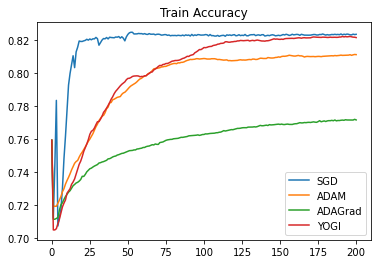

In [107]:
## Compute SGD train & test accuracies ##
sgd_acc = accuracy(D_train, y_train, SGD_weights)
sgd_acc2 = accuracy(D_test, y_test, SGD_weights)

###########
## PLOTS ##
###########

## TRAIN ACCURACY ##
plt.title("Train Accuracy")
plt.plot(sgd_acc, label = "SGD")
plt.plot(adam_acc, label = "ADAM")
plt.plot(adagrad_acc, label = "ADAGrad")
plt.plot(yogi_acc, label = "YOGI")
plt.legend()
plt.show()



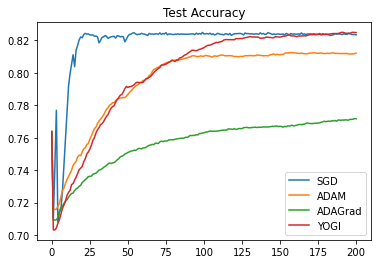

In [108]:
## TEST ACCURACY ##
plt.title("Test Accuracy")
plt.plot(sgd_acc2, label = "SGD")
plt.plot(adam_acc2, label = "ADAM")
plt.plot(adagrad_acc2, label = "ADAGrad")
plt.plot(yogi_acc2, label = "YOGI")
plt.legend()
plt.show()

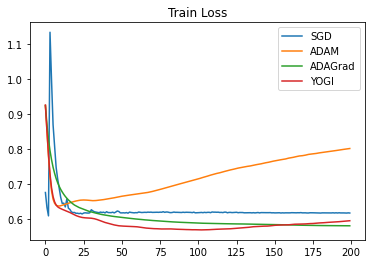

In [112]:

## TRAIN LOSS ##
plt.title("Train Loss")
plt.plot(SGD_loss, label = "SGD")
plt.plot(loss_list, label = "ADAM")
plt.plot(ada_loss_list, label = "ADAGrad")
plt.plot(yogi_weights[1], label = "YOGI")
plt.legend()
plt.show()

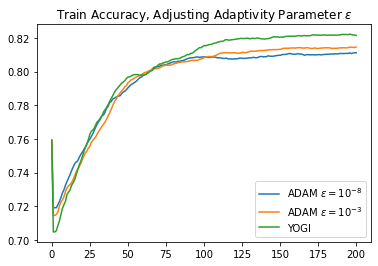

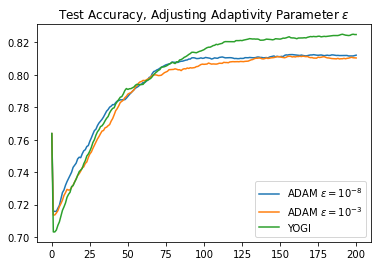

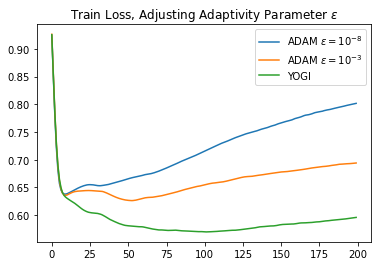

In [131]:
## ACCURACIES & PLOTS FOR CHANGING THE ADAPTIVITY PARAMETER, EPSILON ##

adam_acc_3train = accuracy(D_train, y_train, adam_weights_2)
adam_acc_3test = accuracy(D_test, y_test, adam_weights_2)

plt.title("Train Accuracy, Adjusting Adaptivity Parameter $\epsilon$")
plt.plot(adam_acc, label = r"ADAM $\epsilon = 10^{-8}$")
plt.plot(adam_acc_3train, label = r"ADAM $\epsilon = 10^{-3}$")
plt.plot(yogi_acc, label = "YOGI")
plt.legend()
plt.show()
#plt.subplot(1, 3, 1)

plt.title("Test Accuracy, Adjusting Adaptivity Parameter $\epsilon$")
plt.plot(adam_acc2, label = r"ADAM $\epsilon = 10^{-8}$")
plt.plot(adam_acc_3test, label = r"ADAM $\epsilon = 10^{-3}$")
plt.plot(yogi_acc2, label = "YOGI")
plt.legend()
plt.show()
#plt.subplot(1, 3, 2)


plt.title(r"Train Loss, Adjusting Adaptivity Parameter $\epsilon$")
plt.plot(loss_list, label = r"ADAM $\epsilon = 10^{-8}$")
plt.plot(loss_list_2, label = r"ADAM $\epsilon = 10^{-3}$")
plt.plot(yogi_weights[1], label = "YOGI")
plt.legend()
plt.show()



In [138]:
## DIRECTLY PRINT ACCURACIES & LOSS OF THE MOST RECENT WEIGHTS ##

## Test Accuracies
print("SGD Test Accuracy",sgd_acc2[-1])
print("ADAGrad Test Accuracy",adagrad_acc2[-1])
print("ADAM Test Accuracy",adam_acc2[-1])
print("YOGI Test Accuracy",yogi_acc2[-1])
print()

## Train Accuracies
print("SGD Train Accuracy",sgd_acc[-1])
print("ADAGrad Train Accuracy",adagrad_acc[-1])
print("ADAM Train Accuracy",adam_acc[-1])
print("YOGI Train Accuracy",yogi_acc[-1])
print()

## Train Loss
print("SGD Train Loss",SGD_loss[-1])
print("ADAGrad Train Loss",ada_loss_list[-1])
print("ADAM Train Loss",loss_list[-1])
print("YOGI Train Loss",yogi_weights[1][-1])


SGD Test Accuracy 0.8234137952214238
ADAGrad Test Accuracy 0.7716970702045329
ADAM Test Accuracy 0.8121122781155948
YOGI Test Accuracy 0.8248264848596524

SGD Train Accuracy 0.8234390835662295
ADAGrad Train Accuracy 0.7715057891342404
ADAM Train Accuracy 0.8111237369859648
YOGI Train Accuracy 0.8214735419673843

SGD Train Loss 0.6178757961249691
ADAGrad Train Loss 0.5814680585299414
ADAM Train Loss 0.8017822117136432
YOGI Train Loss 0.5958818516320222


In [140]:
## DIRECTLY PRINT ACCURACIES & LOSS OF MOST RECENT WEIGHTS FOR ADAPTIVITY PARAMETER (2nd set of plots) ##

print("Test Accuracy")
print(r"ADAM $\epsilon = 10^{-8}$", adam_acc2[-1])
print(r"ADAM $\epsilon = 10^{-3}$", adam_acc_3test[-1])
print(r"YOGI $\epsilon = 10^{-3}$", yogi_acc2[-1])
print()

## Train Accuracy
print("Train Accuracy")
print(r"ADAM $\epsilon = 10^{-8}$", adam_acc[-1] )
print(r"ADAM $\epsilon = 10^{-8}$", adam_acc_3train[-1])
print(r"ADAM $\epsilon = 10^{-8}$", yogi_acc[-1])
print()

## Train Loss
print("Train Loss")
print("ADAM Train Loss, eps = 10^-8",loss_list[-1])
print("ADAM Train Loss, eps = 10^-3",loss_list_2[-1])
print("YOGI Train Loss, eps = 10^-3",yogi_weights[1][-1])


Test Accuracy
ADAM $\epsilon = 10^{-8}$ 0.8121122781155948
ADAM $\epsilon = 10^{-3}$ 0.810392482034273
YOGI $\epsilon = 10^{-3}$ 0.8248264848596524

Train Accuracy
ADAM $\epsilon = 10^{-8}$ 0.8111237369859648
ADAM $\epsilon = 10^{-8}$ 0.8146248579589079
ADAM $\epsilon = 10^{-8}$ 0.8214735419673843

Train Loss
ADAM Train Loss, eps = 10^-8 0.8017822117136432
ADAM Train Loss, eps = 10^-3 0.6941227738197732
YOGI Train Loss, eps = 10^-3 0.5958818516320222
